In [1]:
# Set seeds for reproducible results
from numpy.random import seed
seed(327)
import tensorflow
tensorflow.random.set_seed(327)

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn.functional as F

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

import itertools

Using TensorFlow backend.


#### Helper Functions

##### 1. Data Preprocessing

In [2]:
def preprocess_data(raw_data):
    
    # Add categorical dummy variables (All 0s represent)
    tasknum_dummies = pd.get_dummies(raw_data['Task_num'],
                                     prefix="TaskNum") # Create dummy variables
    data = pd.concat([raw_data, tasknum_dummies], axis=1) 

    # Remove the unnecessary columns
    remove_cols = ["Skip_distance",
              "Subject",
              "Mean_fixation_duration",
              "Loag_Fixationtime",
              "Log_timetoF",
              "Task_completion_duration",
              "Compressed_scanpath_value", 
              "Total_r_d",
              "Compressed_M_Minimal",
              "Strictly_linearWID",
              "Mean_fixation_duration_for_onelink",
              "Skip",
              "Skip_count", 
              "Task_num",
              "TaskNum_t9"]  # Remove one dummy variable to avoid the dummy variable trap

    data = data.drop(remove_cols, axis=1)
    
    # Encode the Screen_size column
    vals = ['S', 'M', 'L']
    for i in range(len(vals)):
        data.at[data['Screen_size'] == vals[i], ['Screen_size']] = i    

    # Replace missing values with 0 in column Regression_distance
    preprocessed_data = data.fillna(0)

    # Inspect the number of missing values in the preprocessed_data dataset
    num_missing = preprocessed_data.isnull().sum().sum()
    print("The number of missing values in the data = {}".format(num_missing))
    print("Number of features remaining = {}".format(data.shape[1]))
    
    return preprocessed_data

##### 2. Model Building

In [3]:
def create_model(hidden_neurons, learning_rate, num_epoch, input_neurons = 29, output_neurons=3):
    
    # define the structure of our neural network
    net = torch.nn.Sequential(
        torch.nn.Linear(input_neurons, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, hidden_neurons),
        torch.nn.Sigmoid(),
        torch.nn.Linear(hidden_neurons, output_neurons),
    )

    # define loss functions
    loss_func = torch.nn.CrossEntropyLoss()

    # define optimiser
    optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate)
    
    return net, loss_func, optimiser

##### 3. Train Model

In [4]:
def train_neural_network(model, X_train, y_train):
    
    # create Tensors to hold inputs and outputs. Tensors are data structures
    # similar to numpy matrices. They can be operated on efficiently by a GPU
    # 
    # Note: In torch versions before 0.4, Tensors had to be wrapped in a Variable
    # to be used by the NN.
    X = torch.tensor(X_train.values, dtype=torch.float)
    Y = torch.tensor(y_train.values, dtype=torch.long)
    
    
    # store all losses for visualisation
    all_losses = []

    # train a neural network
    for epoch in range(num_epoch):
        # Perform forward pass: compute predicted y by passing x to the model.
        # Here we pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        # In this case, Y_pred contains three columns, where the index of the
        # max column indicates the class of the instance
        Y_pred = net(X)

        # Compute loss
        # Here we pass Tensors containing the predicted and true values of Y,
        # and the loss function returns a Tensor containing the loss.
        loss = loss_func(Y_pred, Y)
        all_losses.append(loss.item())

        # print progress
#         if epoch % 50 == 0:
#             # convert three-column predicted Y values to one column for comparison
#             _, predicted = torch.max(F.softmax(Y_pred,1), 1)

#             # calculate and print accuracy
#             total = predicted.size(0)
#             correct = predicted.data.numpy() == Y.data.numpy()

#             print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
#                   % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))

        # Clear the gradients before running the backward pass.
        net.zero_grad()

        # Perform backward pass: compute gradients of the loss with respect to
        # all the learnable parameters of the model.
        loss.backward()

        # Calling the step function on an Optimiser makes an update to its
        # parameters
        optimiser.step()
        
    return np.array(all_losses)

##### 4. Evaluate Model

In [5]:
def evaluate(net, x, y, mode='Train'):
    
    # Transform data to tensors
    X = torch.tensor(x.values, dtype=torch.float)
    Y = torch.tensor(y.values, dtype=torch.long) 

    # Create empty 3x3 confusion matrix
    confusion = torch.zeros(3, 3)

    # Make predictions on X
    Y_pred = net(X)
    _, predicted = torch.max(F.softmax(Y_pred,1), 1)

    # Create confusion Matrix
    for i in range(X.shape[0]):
        actual_class = Y.data[i]
        predicted_class = predicted.data[i]

        confusion[actual_class][predicted_class] += 1

    # Calculate Accuracy score
    correct_pred_count = confusion[0,0] + confusion[1,1] + confusion[2,2]
    accuracy_score = correct_pred_count / confusion.sum() * 100

    print("{}ing Accuracy = {}%".format(mode, accuracy_score))    
    print('Confusion matrix for {}ing:'.format(mode))
    print(confusion.numpy())
    
    print("\nClassification Report -")
    print(metrics.classification_report(y, predicted.numpy()))

#### Data Preparation

In [6]:
# Step 1. Import the dataset

# Total number of columns in the dataset = 36
required_cols = list(range(36))

# Read the dataset
raw_data = pd.read_excel("Jae-Second_Exp_data.xlsx",
                     sheet_name="Analysis_summary",
                     nrows=161,
                     usecols = required_cols)

# Step 2. Preprocess the data
data = preprocess_data(raw_data = raw_data)

# Step 3. Split the data into training and test sets

# Divide into features and target variables
X = data.drop("Screen_size", axis=1)
y = data['Screen_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

The number of missing values in the data = 0
Number of features remaining = 30


#### Model Building

In [7]:
# Step 4. Initialise model parameters
hidden_neurons = 32
learning_rate = 0.474
num_epoch = 200

# Step 5. Build model skeleton
net, loss_func, optimiser = create_model(hidden_neurons=hidden_neurons,
                                         learning_rate=learning_rate,
                                         num_epoch=num_epoch)

# Step 6. Train the model and store build history
losses = train_neural_network(net, X_train, y_train)

#### Model evaluation

In [8]:
# Step 7. Evaluate on train and test data
evaluate(net, X_train, y_train)
evaluate(net, X_test, y_test, mode='Test')

Training Accuracy = 44.53125%
Confusion matrix for Training:
[[33.  0. 10.]
 [19.  0. 24.]
 [18.  0. 24.]]

Classification Report -
              precision    recall  f1-score   support

           0       0.47      0.77      0.58        43
           1       0.00      0.00      0.00        43
           2       0.41      0.57      0.48        42

    accuracy                           0.45       128
   macro avg       0.30      0.45      0.35       128
weighted avg       0.29      0.45      0.35       128

Testing Accuracy = 39.39393997192383%
Confusion matrix for Testing:
[[7. 0. 4.]
 [7. 0. 4.]
 [5. 0. 6.]]

Classification Report -
              precision    recall  f1-score   support

           0       0.37      0.64      0.47        11
           1       0.00      0.00      0.00        11
           2       0.43      0.55      0.48        11

    accuracy                           0.39        33
   macro avg       0.27      0.39      0.32        33
weighted avg       0.27      0.

C:\Users\Pandey\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Hyperparamter tuning using Genetic Algorithm

We wish to tune the following hyperparameters for our neural network architecture :
1. Number of hidden layers
2. Neurons per layer
3. Activation Function for the hidden layers
4. Optimizer

In [9]:
def build_nn(num_hidden_layers, neurons_per_layer, activation_function, optimizer, dropout):

    # Initialising the ANN
    classifier = Sequential()

    # Add first hidden layer
    classifier.add(Dense(units = neurons_per_layer, activation = activation_function, input_dim = X_train.shape[1]))

    # Add hidden layers
    for i in range(num_hidden_layers - 1):
        classifier.add(Dense(units = neurons_per_layer, activation = activation_function))
        classifier.add(Dropout(dropout, seed=327))
        
    # Adding the output layer
    classifier.add(Dense(units = 3, activation = 'softmax'))

    # Compiling the ANN
    classifier.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

##### C. Initialise Population

In [10]:
# Step 3. Create the initial population
def initialise_population(population_size):    
    num_parameters = 5  # Number of hyperparameters we wish to tune    
    # Initialize search space
    population = np.zeros((population_size, num_parameters))    
    # Define sample space for initial population
#     num_hidden_layers = np.arange(0, 10)
#     neurons_per_layer = np.arange(5, 100, 5)
#     activation_functions = np.array(['relu', 'tanh', 'selu', 'softsign'])    
#     optimizers = np.array(['sgd', 'rmsprop', 'adam', 'adadelta', 'adagrad', 'adamax', 'nadam'])    
    # Add individuals to the population
    for i in range(population_size):
        # a) Randomly choose attributes from the search space
        nhl = np.random.choice(num_hidden_layers)
        npl = np.random.choice(neurons_per_layer)
        af = np.random.choice(np.arange(len(activation_functions)))
        opt = np.random.choice(np.arange(len(optimizers))) 
        dpt = np.random.choice(dropout)
        # b) Add individual with chosen attributes to the population
        population[i,:] = nhl, npl, af, opt, dpt        
    return population

##### D. Get the fitness score of the members of a population

In [11]:
# Primary function: get_pop_fitness

# Helper functions : 
    # a) translate_params
    # b) build_nn
    # c) get_individual_fitness

def translate_params(params):
    params = params.tolist()
    params[0] = int(params[0])
    params[1] = int(params[1])
    params[2] = activation_functions[int(params[2])]
    params[3] = optimizers[int(params[3])]
    params[4] = params[4]
    return params

def build_nn(num_hidden_layers, neurons_per_layer, activation_function, optimizer, dropout):

    # Initialising the ANN
    classifier = Sequential()

    # Add first hidden layer
    classifier.add(Dense(units = neurons_per_layer, activation = activation_function, input_dim = X_train.shape[1]))

    # Add hidden layers
    for i in range(num_hidden_layers - 1):
        classifier.add(Dense(units = neurons_per_layer, activation = activation_function))
        classifier.add(Dropout(rate=dropout, seed=327))
        
    # Adding the output layer
    classifier.add(Dense(units = 3, activation = 'softmax'))

    # Compiling the ANN
    classifier.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

def get_individual_fitness(nn):
    # Encode labels using dummy variables
    y_train_nn = pd.get_dummies(y_train).values
    # Fit the model
    nn.fit(X_train, y_train_nn, batch_size = 10, epochs = 20, verbose=0)    
    # Make predictions on test data
    preds = nn.predict(X_test).argmax(axis=1)
    # Return weighted F1-score 
    return metrics.f1_score(y_test, preds, average='weighted')

def get_pop_fitness(pop):
    # Initialize empty list of fitness scores
    fit_score = [] 
    # Loop over every member of the population
    for individual in pop: 
        # Get parameters from individual
        num_hidden_layers, neurons_per_layer, activation_function, optimizer, dropout = translate_params(individual)
        # Build a neural network wrt the member's parameters         
        nn = build_nn(num_hidden_layers, neurons_per_layer, activation_function, optimizer, dropout)  
        # Calculate the fitness of the member
        fitness = get_individual_fitness(nn)
        # Add member fitness to record of population fitness
        fit_score.append(fitness)
    # Return the list of fitness scores of the entire population  
    return np.array(fit_score)

##### E. Selecting the best parents in the population for mating

In [12]:
def select_fittest_individuals(population, fitness_scores, n):
    return population[fitness_scores.argsort()[::-1]][:n]

##### F. Reproduction (Single-Point-Crossover)

In [13]:
# Step 6. Generating next generation using crossover

def single_point_crossover(fittest_individuals, n):
    children = []
    # Generate all possible pairs of Fit Individuals for reproduction
    for a, b in itertools.combinations(np.arange(len(fittest_individuals)), 2):        
        # Initialise parents
        parent_A = fittest_individuals[a].copy()
        parent_B = fittest_individuals[b].copy()
        # Randomly select a gene to be switched between both parents
        crossover_idx = np.random.randint(0, 5)
        # Switch that gene between the parents
        parent_B[crossover_idx], parent_A[crossover_idx] = parent_A[crossover_idx], parent_B[crossover_idx]
        # These modified parents are the children for the next generation
        children.append(parent_A)
        children.append(parent_B)
    
    # Indices of all the children 
    all_child_ids = np.arange(len(children))
    # Randomly select 'n' children that survive to the next generation
    survived_child_ids = np.random.choice(all_child_ids, n, replace=False).astype(int)
    children = np.array(children)[survived_child_ids]
    
    return children

##### G. Mutation (all children are mutated)

In [14]:
# Step 7. Adding some variations to the new generation
def mutate(survivors):
    
    m_survivors = survivors.copy()
    
    for survivor in m_survivors:
        # Randomly select a gene to mutate
        gene_id = np.random.randint(0, 5)
        
        # Determine if the mutation is an addition/subtraction operation (50-50 chance of either)
        p = 0.5
        sign = 1 if (np.random.random() > p) else -1

        # Mutate the genes (0 or 1) using values drawn from a gaussian distribution
        if gene_id == 0:
            factor = 3
            mutation = int(np.random.random() * factor)
            survivor[gene_id] += mutation    
            if survivor[gene_id] < 0:
                survivor[gene_id] = 0

        if gene_id == 1:
            factor = 10
            mutation = int(np.random.random() * factor)
            survivor[gene_id] += mutation
            if survivor[gene_id] <= 0:
                survivor[gene_id] = 2
                
        if gene_id == 4:
            factor = 10
            mutation = int(np.random.random() / factor)
            survivor[gene_id] += mutation
            if survivor[gene_id] <= 0:
                survivor[gene_id] = 0
            elif survivor[gene_id] >= 1:
                survivor[gene_id] = 0.99
    
    return m_survivors

In [15]:
# Define sample space for initial population
num_hidden_layers = np.arange(0, 30)
neurons_per_layer = np.arange(5, 100, 5)
activation_functions = np.array(['relu', 'tanh', 'selu', 'softsign'])    
optimizers = np.array(['sgd', 'rmsprop', 'adam', 'adadelta', 'adagrad', 'adamax', 'nadam'])   
dropout = np.random.random(size=30) / 2

In [16]:
%%time
# Step 1. Represent parameters as a chromosome

# Step 2. Defining the population size and number of generations
POPULATION_SIZE = 100
NUM_GENERATIONS = 20

NUM_PARENTS_PER_GENERATION = 30
NUM_CHILDREN_PER_GENRATION = 50
NUM_WEAK_SURVIVORS = POPULATION_SIZE - (NUM_PARENTS_PER_GENERATION + NUM_CHILDREN_PER_GENRATION)

# Book keeping variables
BEST_PERFORMERS = []
BEST_PERFORMERS_FITNESS = []

# Step 3. Creating the initial population.
population = initialise_population(POPULATION_SIZE)

# Repeat for each generation the following
for i in range(NUM_GENERATIONS):
    
    old_population = population
    
    # Step 4. Measure the fitness of each chromosome in the population.
                # by Training and evaluating (f1-scores) for all networks in the population:
    fitness_scores = get_pop_fitness(old_population)
    
    # Step 5. Selecting the best parents in the population for mating.
    fittest_individuals = select_fittest_individuals(old_population, fitness_scores, NUM_PARENTS_PER_GENERATION)
    
    BEST_PERFORMERS.append(fittest_individuals)
    BEST_PERFORMERS_FITNESS.append(np.sort(fitness_scores)[::-1][:len(fittest_individuals)])
    
    # Step 6. Generating next generation using single-point crossover.
    children = single_point_crossover(fittest_individuals, NUM_CHILDREN_PER_GENRATION)
    
    # Step 7. Adding some variations to the population using mutation on children and few weak members.
    children = mutate(children)
    weak_survivors = old_population[fitness_scores.argsort()][:NUM_WEAK_SURVIVORS] # Members with least fitness scores
    weak_survivors = mutate(weak_survivors)
    
    # Step 8. Creating the new population (Fittest, Weakest, Children)
    population = np.concatenate((fittest_individuals, children, weak_survivors), axis=0)
    
    # Step 9. Displaying the best result in the current generation
    generation_best_individual = old_population[fitness_scores.argmax()]
    generation_best_individual = translate_params(generation_best_individual)
    print(generation_best_individual, fitness_scores.max())

# Get the best solution

[6, 60, 'softsign', 'nadam', 0.22397928771922776] 0.6407729468599033
[6, 61, 'softsign', 'nadam', 0.22397928771922776] 0.6190849673202614
[3, 40, 'selu', 'adagrad', 0.13278567718407863] 0.6646464646464647
[1, 95, 'tanh', 'adadelta', 0.25891806232171916] 0.66743961352657
[2, 61, 'softsign', 'nadam', 0.22397928771922776] 0.6218803418803418
[4, 40, 'softsign', 'adagrad', 0.13278567718407863] 0.6353383458646616
[3, 47, 'softsign', 'adagrad', 0.13278567718407863] 0.634481460568417
[3, 40, 'softsign', 'adagrad', 0.13278567718407863] 0.6388888888888888
[4, 70, 'softsign', 'adagrad', 0.13278567718407863] 0.6646325959827104
[4, 70, 'softsign', 'adagrad', 0.13278567718407863] 0.6371428571428571
[4, 70, 'softsign', 'adagrad', 0.13278567718407863] 0.6708496732026145
[4, 86, 'softsign', 'adagrad', 0.22397928771922776] 0.6696227748859327
[4, 72, 'softsign', 'adagrad', 0.13278567718407863] 0.6356470887363336
[5, 78, 'softsign', 'adagrad', 0.25891806232171916] 0.6979735240604806
[4, 72, 'softsign', 'a

In [19]:
# np.save("Parents from EA_continuation(Add Dropout)", BEST_PERFORMERS)
# np.save("Fitness from EA_continuation(Add Dropout)", BEST_PERFORMERS_FITNESS)

In [27]:
b = np.array(BEST_PERFORMERS).reshape((-1, 5))
bf = np.array(BEST_PERFORMERS_FITNESS).ravel()

array([[ 6.        , 60.        ,  3.        ,  6.        ,  0.22397929],
       [ 3.        , 45.        ,  0.        ,  4.        ,  0.11309954],
       [ 4.        , 25.        ,  3.        ,  6.        ,  0.29188527],
       ...,
       [ 3.        , 86.        ,  3.        ,  4.        ,  0.25891806],
       [ 4.        , 86.        ,  3.        ,  4.        ,  0.13278568],
       [ 4.        , 95.        ,  3.        ,  4.        ,  0.25891806]])

In [28]:
df_fit = pd.DataFrame(b, columns=['num_hidden_layers', 'neurons_per_layer', 'activation_functions', 'optimizers', 'dropouts'])
df_fit['fitness_score'] = bf
df_fit = df_fit.sort_values(by='fitness_score', ascending=False)
df_fit['activation_functions'] = df_fit['activation_functions'].apply(lambda x : activation_functions[int(x)])
df_fit['optimizers'] = df_fit['optimizers'].apply(lambda x : optimizers[int(x)])
df_fit

,num_hidden_layers,neurons_per_layer,activation_functions,optimizers,dropouts,fitness_score
390,5.0,78.0,softsign,adagrad,0.258918,0.697974
540,3.0,71.0,softsign,adagrad,0.132786,0.692951
300,4.0,70.0,softsign,adagrad,0.132786,0.670850
570,4.0,93.0,softsign,adagrad,0.132786,0.669841
330,4.0,86.0,softsign,adagrad,0.223979,0.669623
...,...,...,...,...,...,...
25,8.0,55.0,relu,adamax,0.132786,0.390287
26,2.0,5.0,relu,adadelta,0.014486,0.388911
27,12.0,20.0,softsign,adagrad,0.130497,0.387488
28,4.0,55.0,softsign,adadelta,0.113100,0.382820


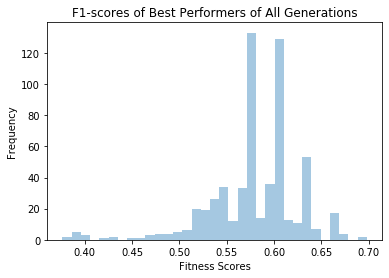

In [29]:
sns.distplot(df_fit.fitness_score, kde=False)
plt.xlabel("Fitness Scores")
plt.ylabel("Frequency")
plt.title("F1-scores of Best Performers of All Generations")
plt.show()

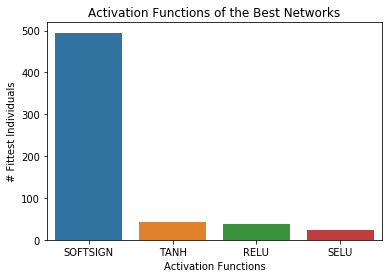

In [30]:
af = df_fit.activation_functions.value_counts()
sns.barplot(af.index.str.upper(), af.values, orient='v')
plt.xlabel("Activation Functions")
plt.ylabel("# Fittest Individuals")
plt.title("Activation Functions of the Best Networks")
plt.show()

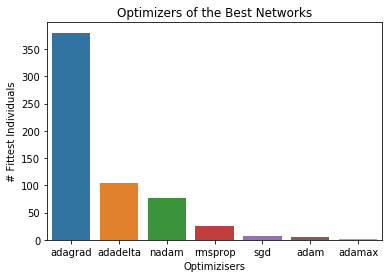

In [31]:
opt = df_fit.optimizers.value_counts()
sns.barplot(opt.index, opt.values, orient='v')
plt.xlabel("Optimizisers")
plt.ylabel("# Fittest Individuals")
plt.title("Optimizers of the Best Networks")
plt.show()

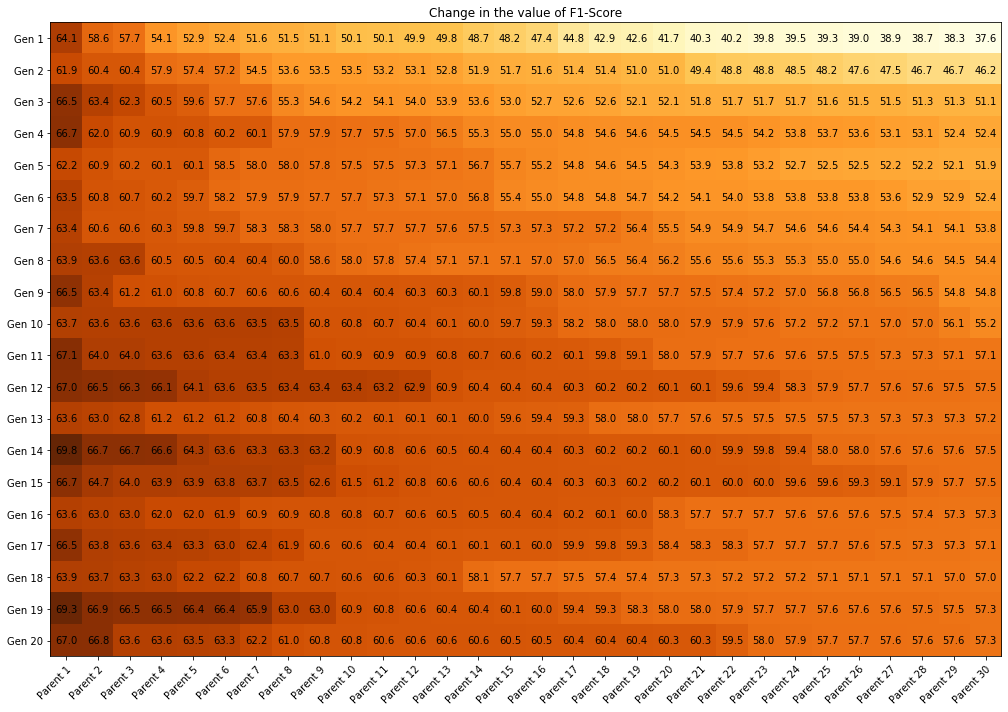

In [32]:
def plot_parameters(numberOfGenerations, numberOfParents, parameter, parameterName):
    #inspired from https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
    generationList = ["Gen {}".format(i+1) for i in range(numberOfGenerations)]
    populationList = ["Parent {}".format(i+1) for i in range(numberOfParents)]
    
    fig, ax = plt.subplots(figsize=(20,10))
    im = ax.imshow(parameter, cmap=plt.get_cmap('YlOrBr'))
    
    # show ticks
    ax.set_xticks(np.arange(len(populationList)))
    ax.set_yticks(np.arange(len(generationList)))
    
    # show labels
    ax.set_xticklabels(populationList)
    ax.set_yticklabels(generationList)
    
    # set ticks at 45 degrees and rotate around anchor
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    
    # insert the value of the parameter in each cell
    for i in range(len(generationList)):
        for j in range(len(populationList)):
            text = ax.text(j, i, np.round(np.array(parameter)*100,1)[i, j],
                           ha="center", va="center", color="k")
    
    ax.set_title("Change in the value of " + parameterName)
    fig.tight_layout()
    plt.show()

plot_parameters(NUM_GENERATIONS, NUM_PARENTS_PER_GENERATION, BEST_PERFORMERS_FITNESS, "F1-Score")